# Neural network from scratch.

Based on YSDA Deep Learning course materials.

# https://github.com/yandexdataschool/Practical_DL/blob/spring2019/homework01/homework_modules.ipynb

We will implement most common layers using `numpy` for matrix operations. 

The file `modules.py` contains the abstract classes for **module**, **criterion** and **sequential** model class.

**Module** is an abstract class which defines the fundamental methods required for training a neural network.

**Criterion** class implements a container which can be used to score the models answers. 

**Sequential** class implements a container which processes `input` data sequentially. 


#### Tips and tricks
Original `numpy` operation are preferable to the overloaded ones (`+`, `*`, `-`, etc. vs `np.add`, `np.multiply`, `np.substract`). They are less prone to excess memory usage and seem unified with tensor frameworks.

*Example:*

```
a = np.zeros_like(arr1)

a = arr1 + arr2 #  bad, we reallocate memory for the result of + operation

a = np.zeros_like(arr1)

np.add(arr1, arr2, out=a) #  good, we use same allocated memory, no need to call gc
```

But I won't follow that advice ;)

In [3]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display


In [4]:
# ! wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/21f_made/week0_07_intro_to_dl/modules.py

from modules import Module, Sequential, Criterion

## Impelementing main layers


Let's try to implement some layers in numpy. 
Today we are going to discuss only the most common ones.

https://en.wikipedia.org/wiki/Matrix_calculus



[Post about einsum](https://habr.com/ru/post/544498/)

### 1. Linear transform layer
Also known as dense layer, fully-connected layer, FC-layer, InnerProductLayer (in caffe), affine transform
- input:   **`batch_size x n_in`**
- output  **`batch_size x n_out`**

[Backpropagation for a Linear Layer handout](http://cs231n.stanford.edu/handouts/linear-backprop.pdf)

In [30]:
class Linear(Module):
    """
    A module which applies a linear transformation 
    A common name is fully-connected layer, InnerProductLayer in caffe. 
    
    The module should work with 2D _input of shape (n_samples, n_feature).
    """
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()
       
        # This is a nice initialization
        stdv = 1./np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size = (n_in, n_out))
        self.b = np.random.uniform(-stdv, stdv, size = n_out)
        
        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)
        
    def updateOutput(self, _input):
        # Your code goes here. ################################################
       # print(_input)
       # print(self.W)
        self.output = np.matmul(_input, self.W) + self.b[None,:]
        return self.output
    
    def updateGradInput(self, _input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = np.matmul(gradOutput, self.W.T)
        return self.gradInput
    
    def accGradParameters(self, _input, gradOutput):
        # Your code goes here. ################################################
        # self.gradW = ... ; self.gradb = ...
        self.gradW += np.matmul(_input.T, gradOutput)
        self.gradb += np.sum(gradOutput, axis=0) # ??? axis = 0 or 1
    
    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)
        
    def getParameters(self):
        return [self.W, self.b]
    
    def getGradParameters(self):
        return [self.gradW, self.gradb]
    
    def __repr__(self):
        s = self.W.shape
        q = 'Linear %d -> %d' %(s[1],s[0])
        return q

In [6]:
a = Linear(5, 4)
a.forward(np.arange(10).reshape( (2, 5)))

array([[-1.4214039 , -1.69213333, -0.15181919, -0.93510292],
       [-2.2742714 , -5.30317348, -0.38187717, -2.00914283]])

### 2. SoftMax
- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

$\text{softmax}(x)_i = \frac{\exp x_i} {\sum_j \exp x_j}$

Recall that $\text{softmax}(x) == \text{softmax}(x - \text{const})$. It makes possible to avoid computing exp() from large argument.

[Notes on softmax](https://deepnotes.io/softmax-crossentropy)

In [7]:

p = np.arange(6).reshape((2, 3))
np.einsum('bi,bj->bij', p, p)

array([[[ 0,  0,  0],
        [ 0,  1,  2],
        [ 0,  2,  4]],

       [[ 9, 12, 15],
        [12, 16, 20],
        [15, 20, 25]]])

In [8]:
class SoftMax(Module):
    def __init__(self):
         super(SoftMax, self).__init__()
    
    def updateOutput(self, _input):
        # start with normalization for numerical stability
        self.output = np.subtract(_input, _input.max(axis=1, keepdims=True)) #to not call large argument?
         
        self.output = np.exp(self.output)
        self.output = self.output / np.sum(self.output, axis=1, keepdims=True)
        
        return self.output
    
    def updateGradInput(self, _input, gradOutput):
          ################################################
        # First we create for each example feature vector, it's outer product with itself
        # ( p1^2  p1*p2  p1*p3 .... )
        # ( p2*p1 p2^2   p2*p3 .... )
        # ( ...                     )
        local_repr1 = np.einsum('bi,bj->bij', self.output, self.output)
        # your code here 
        # Second we need to create an (n_feats, n_feats) identity of the feature vector
        # ( p1  0  0  ...  )
        # ( 0   p2 0  ...  )
        # ( ...            )
        # your code here 
        local_repr2 = np.einsum('bi,ij->bij', self.output, np.eye(_input.shape[1], _input.shape[1]))
        # Then we need to subtract the first tensor from the second
        # ( p1 - p1^2   -p1*p2   -p1*p3  ... )
        # ( -p1*p2     p2 - p2^2   -p2*p3 ...)
        # ( ...                              )
        # your code here 
        local_repr = local_repr2 - local_repr1
        self.gradInput = np.einsum('bij,bi->bj', local_repr, gradOutput)
        ################################################
        return self.gradInput
    
    def __repr__(self):
        return "SoftMax"

In [22]:
q = np.array([1,2,3,4])
p = np.array([1,1,1,1]).reshape(4,1)
print(p.shape)
print(q.shape)

(4, 1)
(4,)


In [23]:
class LogSoftMax(Module):
    def __init__(self):
         super(LogSoftMax, self).__init__()
    
    def updateOutput(self, _input):
        # start with normalization for numerical stability
        self.output = np.subtract(_input, _input.max(axis=1, keepdims=True))
        self.output = np.exp(self.output)
        self.output = np.log(self.output / np.sum(self.output, axis=1, keepdims=True))
        # Your code goes here. ################################################

        return self.output
    
    def updateGradInput(self, _input, gradOutput):
        # Your code goes here. ################################################
        local_repr2 = np.einsum('bi,bj->bij', np.ones(_input.shape[1]), self.output)
        local_repr = np.eye(_input.shape[1], _input.shape[1]) - local_repr2
        self.gradInput = np.einsum('bij,bi->bj', local_repr, gradOutput)
        return self.gradInput
    
    def __repr__(self):
        return "LogSoftMax"

### 3. Negative LogLikelihood criterion (numerically unstable)
[multiclass log loss](http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss). Remember that targets are one-hot encoded. Note, that criterions are the only places, where you divide by batch size. Also there is a small hack with adding small number to probabilities to avoid computing log(0).
- input:   **`batch_size x n_feats`** - probabilities
- target: **`batch_size x n_feats`** - one-hot representation of ground truth
- output: **scalar**## 



In [24]:
class ClassNLLCriterionUnstable(Criterion):
    EPS = 1e-15
    def __init__(self):
        a = super(ClassNLLCriterionUnstable, self)
        super(ClassNLLCriterionUnstable, self).__init__()
        
    def updateOutput(self, input, target):   
        ################################################
        # Use clipping trick to avoid numerical errors
        # your code here 
        ################################################
        clipped_input = np.clip(input, self.EPS, 1 - self.EPS)
        self.output = -np.sum(target * np.log(clipped_input))  / input.shape[0]
        return self.output

    def updateGradInput(self, input, target):
        ################################################
        # Use clipping trick to avoid numerical errors
        # your code here 
        ################################################
        clipped_input = np.clip(input, self.EPS, 1 - self.EPS)
        self.gradInput = -(target / clipped_input) / input.shape[0]
        return self.gradInput
    
    def __repr__(self):
        return "ClassNLLCriterionUnstable"

In [ ]:
class ClassNLLCriterion(Criterion):
    def __init__(self):
        a = super(ClassNLLCriterion, self)
        super(ClassNLLCriterion, self).__init__()
        
    def updateOutput(self, _input, target): 
        # Your code goes here. ################################################
        self.output = -np.sum(target * _input)  / _input.shape[0]
        return self.output

    def updateGradInput(self, _input, target):
        # Your code goes here. ################################################
        self.gradInput = -(target / np.exp(_input) / _input.shape[0])
        return self.gradInput
    
    def __repr__(self):
        return "ClassNLLCriterion"

In [36]:
def simple_sgd(variables, gradients, config, state):  
    # 'variables' and 'gradients' have complex structure, accumulated_grads will be stored in a simpler one
    state.setdefault('accumulated_grads', {})
    
    var_index = 0 
    for current_layer_vars, current_layer_grads in zip(variables, gradients): 
        for current_var, current_grad in zip(current_layer_vars, current_layer_grads):
            
            current_var -= config['learning_rate'] * current_grad
            var_index += 1     

## Toy training example

Use this example to debug your code, just logistic regression. You do not need to change anything here. This code is provided for you to test the layers. 

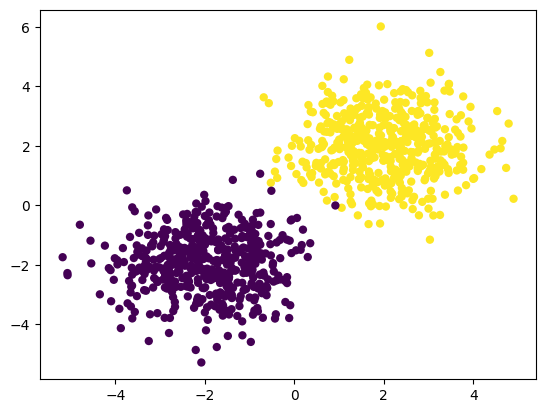

In [31]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [32]:
net = Sequential()
net.add(Linear(2, 2))

net.add(SoftMax())
criterion = ClassNLLCriterionUnstable()

print(net)

Linear 2 -> 2
SoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [33]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [34]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

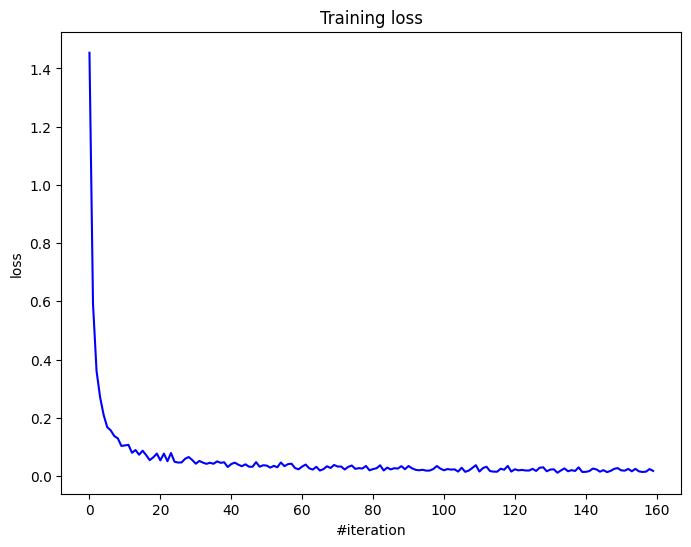

Current loss: 0.017374


In [37]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        simple_sgd(net.getParameters(), 
                   net.getGradParameters(), 
                   optimizer_config,
                   optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    